# **Pairing Averaged**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection


import Materials_Parameters as mp
from MTI_Discretization import eigenstates_Dirichlet as eigenstates
from MTI_Second_Order import FMTI2_NeumannBC, Change_Basis, Block_Reverse

# parameters
d = 100.; mu = 0.010; Delta = 0.005
# coupling matrices
Gamma = np.matrix([[1,0],[0,1],[1,0],[0,1]])

## Finite Magnetization $\Lambda = 20$ meV

#### **Energy Spectrum**

In [5]:
# lattice
Nlat = 100; d = 100.; dZ = d/(Nlat-1)

egval = []; spinors = []
momentum = np.linspace(-0.15, 0.15, 101)

for k in momentum:

    # eigenstates
    lattice, egv, wf = eigenstates(Nlat=Nlat, dZ=dZ, kx = k, ky = 0., L = 0.030)

    # indices for sorting by absolute value
    idx_sort = np.argsort(egv)
    # sort egval accordingly
    egv = egv[idx_sort]
    # sort wf accordingly
    wf = wf[idx_sort, :, :]   
    
    egval.append(egv); spinors.append(wf) 


egval = np.array(egval)
spinors = np.array(spinors)

print(egval.shape, spinors[0].shape)

(101, 400) (400, 100, 4)


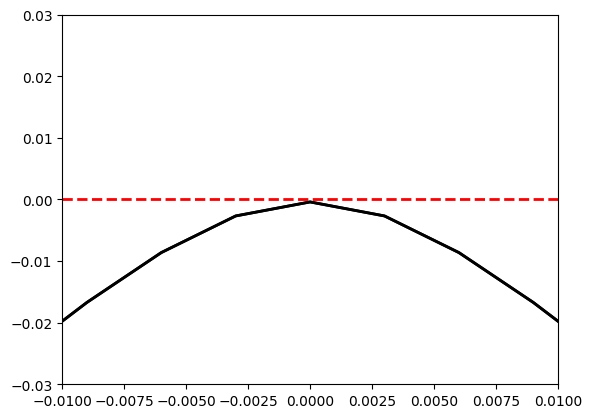

In [6]:
# figure
fig, ax = plt.subplots(1)
# horizontal line zero energy
ax.axhline(0, ls='--', lw=2, c='red')

n = 50
for idx in range(n):
    
    # index for eigenvalues around zero energy
    iegv = 200 - int(n/2) + idx 

    # plot eigenvalues
    ax.plot(momentum, egval[:,iegv], c='black', lw=2)

#ax.set_xlim(-0.1,0.1);
#ax.set_ylim(-0.3,0.3);

ax.set_xlim(-0.01,0.01);
ax.set_ylim(-0.03,0.03);

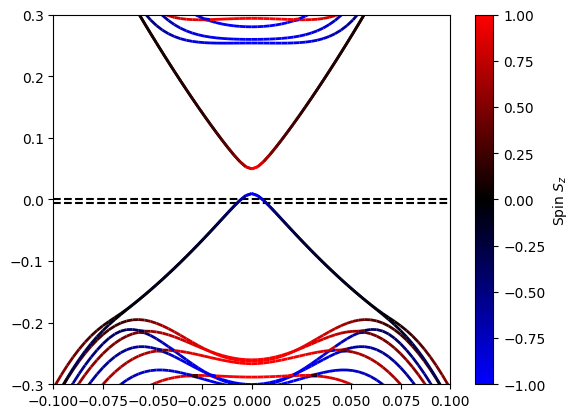

In [4]:
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap

# Custom colormap with wide black region
colors = [
    (0.0, (0, 0, 1)),   # blue at left
    (0.5, (0, 0, 0)),   # black starts early
    (0.5, (0, 0, 0)),   # black ends late
    (1.0, (1, 0, 0))    # red at right
]

# Create the colormap
cmap = LinearSegmentedColormap.from_list("blue_wideblack_red", colors, N=256)

# figure
fig, ax = plt.subplots(1)
# horizontal line zero energy
ax.axhline(0, ls='--', lw=1.5, c='black')
ax.axhline(-0.005, ls='--', lw=1.5, c='black')

# number of k values
k_dim = spinors.shape[0]
# normalize between -1 and 1
norm = Normalize(vmin=-1, vmax=1)

# Sz operator in orbital x spin basis
Sz = np.kron(np.eye(2), np.array([[1, 0], [0, -1]]))


n = 50
for idx in range(n):
    
    # eigenstate index
    iegv = 200 - int(n/2) + idx 

    # get spin z for colors
    spin_z = [np.sum([np.vdot(s, Sz @ s).real for s in spinors[kdx,iegv]]) for kdx in range(k_dim)]
    
    # define x and y arrays for plot
    x,y = momentum, egval[:,iegv]
    
    # create line segments between consecutive points
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # create LineCollection
    lc = LineCollection(segments, cmap=cmap, array=spin_z[:-1], lw=2, norm=norm)

    # plot line
    line = ax.add_collection(lc)

fig.colorbar(line, ax=ax, label="Spin $S_z$")

ax.set_xlim(-0.1,0.1);
ax.set_ylim(-0.3,0.3);

#ax.set_xlim(-0.015, 0.015);
#ax.set_ylim(-0.05, 0.05);

#fig.savefig('PPT/MTI_p20_spectrum_zoom.pdf', bbox_inches='tight', pad_inches=0.1)
#fig.savefig('PPT/MTI_p20_spectrum_zoom.svg', bbox_inches='tight', pad_inches=0.1)

#### **Magnetization Effect**

In [7]:
# lattice
Nlat = 100; d = 100.; dZ = d/(Nlat-1)

egval_mag = []; spinors_mag = []
Zeeman = np.linspace(0., 0.050, 50)

for L in Zeeman:

    # eigenstates
    lattice, egv, wf = eigenstates(Nlat=Nlat, dZ=dZ, kx = 0., ky = 0., L=L)

    # indices for sorting by absolute value
    idx_sort = np.argsort(egv)
    # sort egval accordingly
    egv = egv[idx_sort]
    # sort wf accordingly
    wf = wf[idx_sort, :, :]   
    
    egval_mag.append(egv); spinors_mag.append(wf) 


egval_mag = np.array(egval_mag)
spinors_mag = np.array(spinors_mag)

print(egval_mag.shape, spinors_mag[0].shape)

(50, 400) (400, 100, 4)


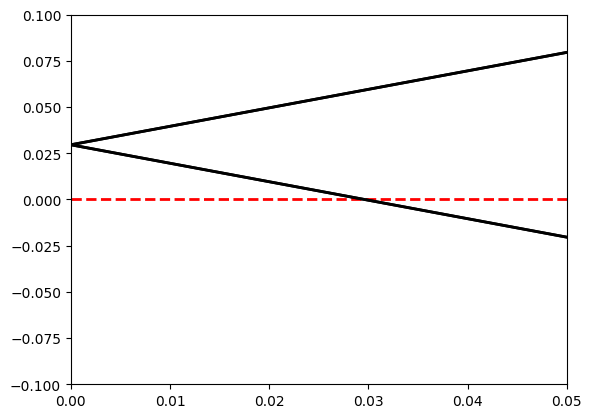

In [13]:
# figure
fig, ax = plt.subplots(1)
# horizontal line zero energy
ax.axhline(0, ls='--', lw=2, c='red')

n = 50
for idx in range(n):
    
    # index for eigenvalues around zero energy
    iegv = 200 - int(n/2) + idx 

    # plot eigenvalues
    ax.plot(Zeeman, egval_mag[:,iegv], c='black', lw=2)

ax.set_xlim(-0.,0.050);
ax.set_ylim(-0.1,0.1);

#### **Induced Pairing**

In [5]:
# shape of the matrix 
n = 4

# space dimensions
K = []; Z = []
k_dim = 100; z_dim = 100

# read file pairing
rows = np.loadtxt("Pairing/pairing_L-p20.txt")

# store data in matrices
F_data = np.empty((k_dim, z_dim, 4, 4), dtype='complex')


# loop over momenta
for idx in range(k_dim):
    
    # loop over space
    for jdx in range(z_dim):

        # index for rows
        irow = z_dim * idx + jdx
                
        # read one row
        row = rows[irow]
    
        if jdx == 0: K.append(float(row[0]))
    
        if idx == 0: Z.append(float(row[1]))
    
        # real part
        real = row[2 : 2 + n*n].reshape((n, n))
        # imaginary part
        imag = row[2 + n*n :].reshape((n, n))
        # pairing matrix
        matrix = real + 1j * imag

        F_data[idx][jdx] = Change_Basis(matrix)

print(F_data.shape)

(100, 100, 4, 4)


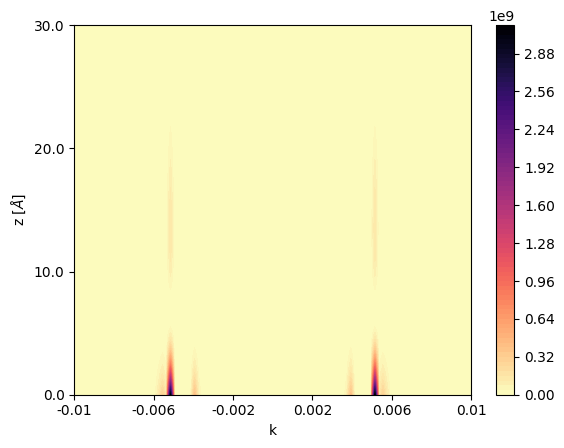

In [6]:
# norm of the induced pairing
F = np.linalg.norm(F_data, axis=(2,3))

contour = plt.contourf(F.T, levels=100, cmap='magma_r')
plt.colorbar(contour)

y_ticks = np.linspace(0, len(Z)-1, 4)
y_labels = np.linspace(Z[0], Z[-1], 4)

x_ticks = np.linspace(0, len(K)-1, 6)
x_labels = np.linspace(K[0], K[-1], 6)


plt.xticks(x_ticks, x_labels);
plt.yticks(y_ticks, y_labels);

plt.xlabel('k')
plt.ylabel('z [$\AA$]');

#plt.savefig('PPT/MTI_p20_pair.pdf', bbox_inches='tight', pad_inches=0.1)
#plt.savefig('PPT/MTI_p20_pair.svg', bbox_inches='tight', pad_inches=0.1)

### **Spin Symmetry**

In [7]:
# swap spin only
F_swap = np.array([[Block_Reverse(f) for f in F1] for F1 in F_data])

# matrices for signlet
F_odd = 0.5*(F_data - F_swap)
# matrices for triplet
F_even = 0.5*(F_data + F_swap)


# spin singlet S=0 part
Fs_0 = np.sqrt(2)*F_odd[:, :, 0:2, 2:4]; fs_0 = np.linalg.norm(Fs_0, axis=(2, 3))

# spin triplet S=0 part
Ft_0 = np.sqrt(2)*F_even[:, :, 0:2, 2:4]; ft_0 = np.linalg.norm(Ft_0, axis=(2, 3))
# spin triplet S=1 part
Ft_p1 = F_even[:, :, 0:2, 0:2]; ft_p1 = np.linalg.norm(Ft_p1, axis=(2, 3))
# spin triplet S=-1 part
Ft_m1 = F_even[:, :, 2:4, 2:4]; ft_m1 = np.linalg.norm(Ft_m1, axis=(2, 3))


# total singlet component
fs = fs_0
# total triplet component
ft = np.sqrt( ft_0*ft_0 + ft_p1*ft_p1 + ft_m1*ft_m1  )

# normalize 
norm = np.max(fs+ft)

print(fs.shape, ft.shape)

(100, 100) (100, 100)


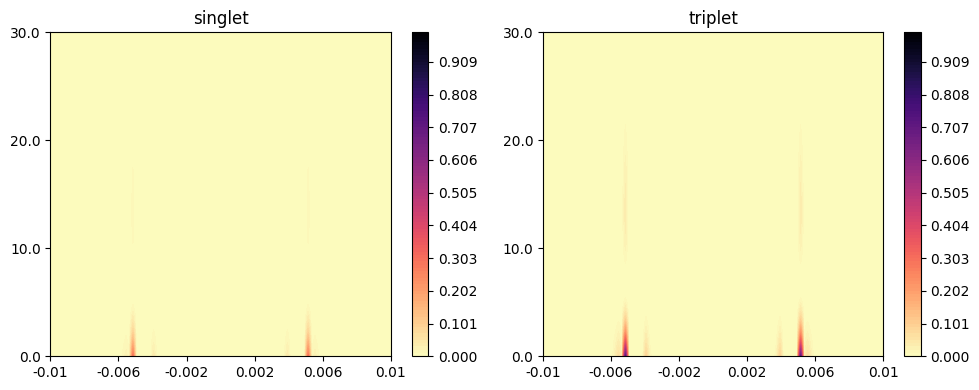

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

# First contour plot
c1 = axes[0].contourf(fs.T/norm, levels=np.linspace(0,1, 100),  cmap='magma_r', vmin=0, vmax=1)
fig.colorbar(c1, ax=axes[0])
axes[0].set_title('singlet')

# Second contour plot
c2 = axes[1].contourf(ft.T/norm, levels=np.linspace(0,1, 100), cmap='magma_r', vmin=0, vmax=1)
fig.colorbar(c2, ax=axes[1])
axes[1].set_title('triplet')

for ax in axes:
    ax.set_xticks(x_ticks, x_labels);
    ax.set_yticks(y_ticks, y_labels);


plt.tight_layout()
plt.show()

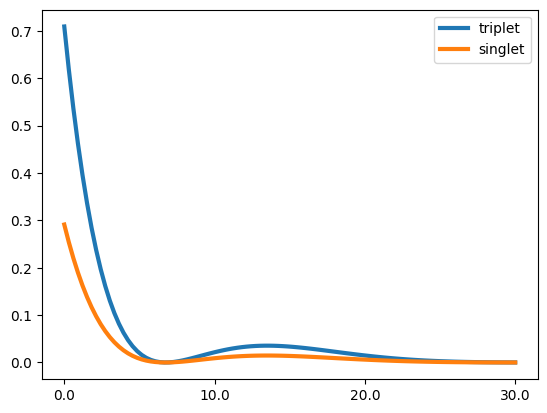

In [9]:
norm = np.sum(fs+ft, axis=0)[0]

plt.plot(np.sum(ft, axis=0)/norm, lw=3, label='triplet')
plt.plot(np.sum(fs, axis=0)/norm, lw=3, label='singlet')

plt.xticks(y_ticks, y_labels);
plt.legend();

#plt.savefig('PPT/MTI_p20_spin_symm.pdf', bbox_inches='tight', pad_inches=0.1)
#plt.savefig('PPT/MTI_p20_spin_symm.svg', bbox_inches='tight', pad_inches=0.1)

#### **Triplet Components**

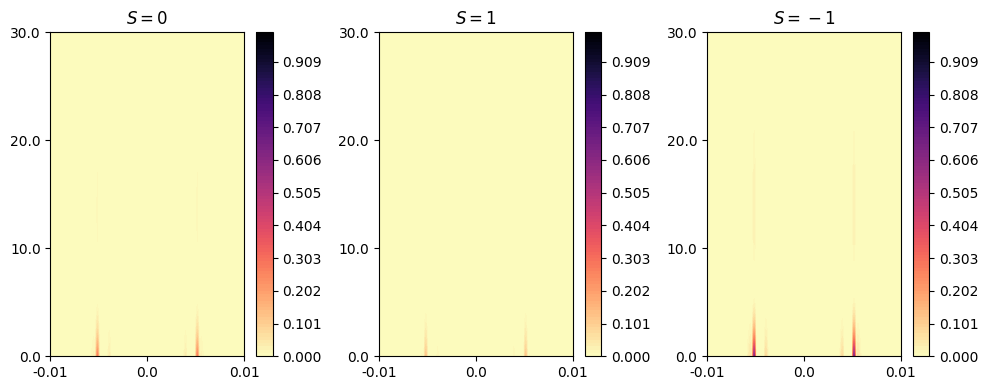

In [10]:
norm = np.max(ft_0+ft_p1+ft_m1)

fig, axes = plt.subplots(1, 3, figsize=(10, 4))  # 1 row, 2 columns

# First contour plot
c1 = axes[0].contourf(ft_0.T/norm, cmap='magma_r', levels=np.linspace(0,1, 100),)
fig.colorbar(c1, ax=axes[0])
axes[0].set_title('$S=0$')

# Second contour plot
c2 = axes[1].contourf(ft_p1.T/norm, cmap='magma_r', levels=np.linspace(0,1, 100),)
fig.colorbar(c2, ax=axes[1])
axes[1].set_title('$S=1$')

# Third contour plot
c3 = axes[2].contourf(ft_m1.T/norm, cmap='magma_r', levels=np.linspace(0,1, 100),)
fig.colorbar(c3, ax=axes[2])
axes[2].set_title('$S=-1$')


x_ticks = np.linspace(0, len(K)-1, 3)
x_labels = np.linspace(K[0], K[-1], 3)

for ax in axes:
    ax.set_xticks(x_ticks, x_labels);
    ax.set_yticks(y_ticks, y_labels);
    
plt.tight_layout()
plt.show()

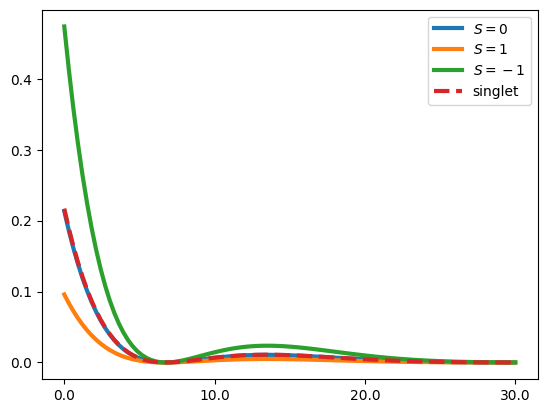

In [11]:
norm = np.sum(ft_0+ft_p1+ft_m1+fs_0, axis=0)[0]

plt.plot(np.sum(ft_0, axis=0)/norm, lw=3, label='$S=0$')
plt.plot(np.sum(ft_p1, axis=0)/norm, lw=3, label='$S=1$')
plt.plot(np.sum(ft_m1, axis=0)/norm, lw=3, label='$S=-1$')

plt.plot(np.sum(fs_0, axis=0)/norm, lw=3, label='singlet', ls='--')

plt.xticks(y_ticks, y_labels);

plt.legend();

#plt.savefig('PPT/MTI_p20_spin_comp.pdf', bbox_inches='tight', pad_inches=0.1)
#plt.savefig('PPT/MTI_p20_spin_comp.svg', bbox_inches='tight', pad_inches=0.1)

### **Momentum Symmetry**

In [12]:
# reverse momentum
F_krev = F_data[::-1, :, :, :]

# matrices for even components
F_even = 0.5*(F_data + F_krev)
# matrices for odd components
F_odd = 0.5*(F_data - F_krev)

fe = np.linalg.norm(F_even, axis=(2, 3))
fo = np.linalg.norm(F_odd, axis=(2, 3))
norm = np.max(fe+fo)

print(fs.shape, ft.shape)

(100, 100) (100, 100)


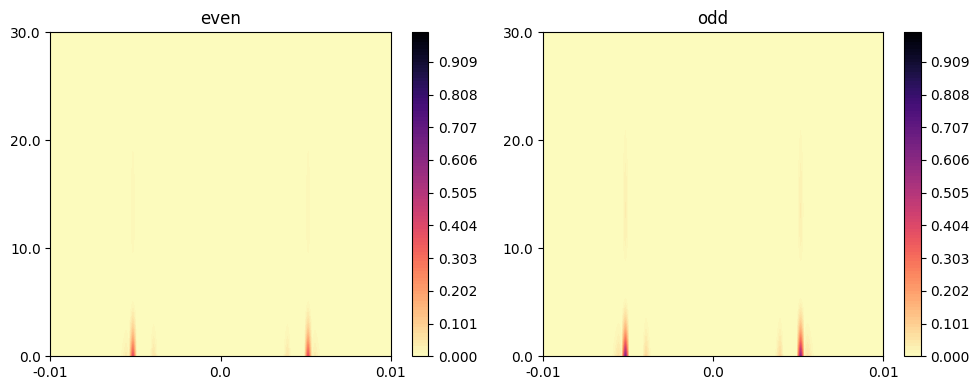

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

# First contour plot
c1 = axes[0].contourf(fe.T/norm, levels=np.linspace(0,1, 100),  cmap='magma_r', vmin=0, vmax=1)
fig.colorbar(c1, ax=axes[0])
axes[0].set_title('even')

# Second contour plot
c2 = axes[1].contourf(fo.T/norm, levels=np.linspace(0,1, 100), cmap='magma_r', vmin=0, vmax=1)
fig.colorbar(c2, ax=axes[1])
axes[1].set_title('odd')


for ax in axes:
    ax.set_xticks(x_ticks, x_labels);
    ax.set_yticks(y_ticks, y_labels);


plt.tight_layout()
plt.show()

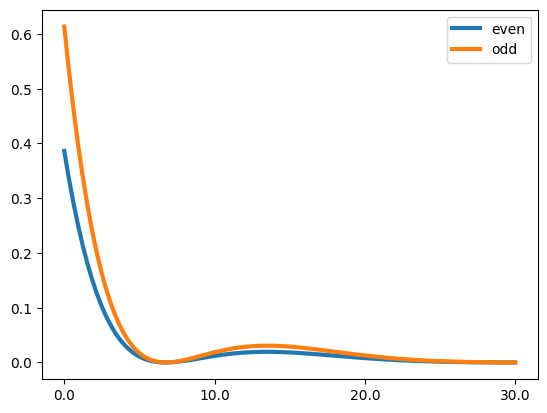

In [14]:
norm = np.sum(fe+fo, axis=0)[0]

plt.plot(np.sum(fe, axis=0)/norm, lw=3, label='even')
plt.plot(np.sum(fo, axis=0)/norm, lw=3, label='odd')
#plt.plot(np.sum(fe+fo, axis=0)/norm, lw=2, c='black')

plt.xticks(y_ticks, y_labels);
plt.legend();

#plt.savefig('PPT/MTI_p20_mom_symm.pdf', bbox_inches='tight', pad_inches=0.1)
#plt.savefig('PPT/MTI_p20_mom_symm.svg', bbox_inches='tight', pad_inches=0.1)

### **Frequency Symmetry**

In [15]:
# shape of the matrix 
n = 4

# space dimensions
E = []; Z = []
e_dim = 100; z_dim = 100

# read file pairing
rows = np.loadtxt("Pairing/avgk/avgk_pairing_L-p20.txt")

# store data in matrices
F_avgk = np.empty((e_dim, z_dim, 4, 4), dtype='complex')


# loop over energies
for idx in range(e_dim):
    
    # loop over space
    for jdx in range(z_dim):

        # index for rows
        irow = z_dim * idx + jdx
                
        # read one row
        row = rows[irow]
    
        if jdx == 0: E.append(float(row[0]))
    
        if idx == 0: Z.append(float(row[1]))
    
        # real part
        real = row[2 : 2 + n*n].reshape((n, n))
        # imaginary part
        imag = row[2 + n*n :].reshape((n, n))
        # pairing matrix
        matrix = real + 1j * imag

        F_avgk[idx][jdx] = Change_Basis(matrix)

print(F_avgk.shape)

(100, 100, 4, 4)


(100, 100) (100, 100)


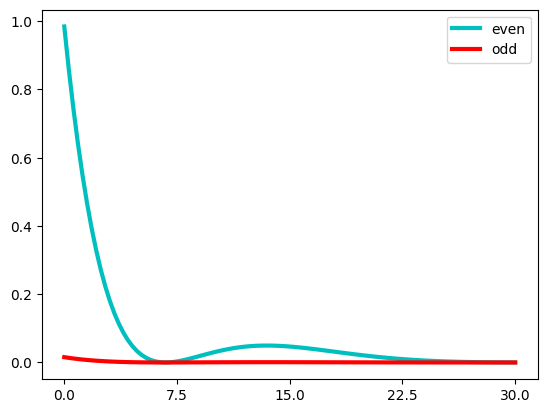

In [16]:
# reverse energy
F_wrev = F_avgk[::-1, :, :, :]

# matrices for even components
F_even_w = 0.5*(F_avgk + F_wrev)
# matrices for odd components
F_odd_w = 0.5*(F_avgk - F_wrev)

fe_w = np.linalg.norm(F_even_w, axis=(2, 3))
fo_w = np.linalg.norm(F_odd_w, axis=(2, 3))
norm = np.sum(fe_w+fo_w, axis=0)[0]

plt.plot(np.sum(fe_w, axis=0)/norm, lw=3, label='even', c='c')
plt.plot(np.sum(fo_w, axis=0)/norm, lw=3, label='odd', c='r')


y_ticks = np.linspace(0, len(Z)-1, 5)
y_labels = np.round(np.linspace(Z[0], Z[-1], 5),3)

plt.xticks(y_ticks, y_labels);
plt.legend();

print(fe_w.shape, fo_w.shape)

#plt.savefig('PPT/MTI_p20_freq_symm.pdf', bbox_inches='tight', pad_inches=0.1)
#plt.savefig('PPT/MTI_20_freq_symm.svg', bbox_inches='tight', pad_inches=0.1)